### HT table results for inhibitory subclasses

In [23]:
source("./scale.R")
test <- read.csv("/data/sag_data.csv")
options(warn=-1)

In [2]:
seeds <- sample(1:100,5,replace=FALSE)
seeds

[1] 25 42 69 17 61

In [3]:
library('foreach')
library('doParallel')
cores=detectCores()
cl <- makeCluster(cores[1]-1) #not to overload your computer
registerDoParallel(cl)

Loading required package: iterators

Loading required package: parallel



## HT table calculation

In [4]:
ecdf_fun <- function(x,perc) ecdf(x)(perc)
## Calculate column stats for each type
calc_pp_2d<-function(typ,pp,ps,section){
    nnp <- c()
    nni <- c()
    mnn <- c()
    res<- list()
    for (i in 1:length(pp)){     
        perc<- ecdf_fun(nndist(pp[[i]]), 0.01)
        int<- intensity(pp[[i]])
        mval<- mean(marks(pp[[i]]))
        nnp<-append(nnp,perc)
        nni<-append(nni,int)
        mnn <- append(mnn, mval)
        res[[as.character(section[i])]] = min(ps[,i])    
    }   
    pval <- signif(fisher(unname(unlist(res)))$p,2)
    res[['pval']] = pval
    res[['perc']] = round(mean(nnp)*100,2)
    res[['lam']] = round(mean(nni))
    res[['conf']] = round(mean(mnn),2)
    res[['rm']] = length(ps[,1])
    res[['Cluster']] = typ
    return(res)
}

### Subclass level

In [5]:
types<-c('046 Vip Gaba','049 Lamp5 Gaba','052 Pvalb Gaba','053 Sst Gaba')
sections<- list(c(24,22,20),c(22),c(24,23,21,20),c(21))

In [6]:
df = data.frame(matrix(vector(), 0, 11,
                dimnames=list(c(), c('Cluster','24','23','22','21','20',"pval", "perc", "lam",'conf','rm'))),
                stringsAsFactors=F)
df$Cluster <- as.character(df$Cluster)
df

Cluster,X24,X23,X22,X21,X20,pval,perc,lam,conf,rm
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>


In [7]:
set.seed(seeds[1]) 
res1 <- foreach(t = 0:length(types), .combine=function(x,y) bind_rows(as.data.frame(x),as.data.frame(y)),.packages=c('dplyr','spatstat','poolr')) %dopar% {
    if (t == 0){
        q <- df
    }
    else{
        pp<-create_pp(test, 'FULL',sections[[t]], types[t])
        rm<-min(as.numeric(quantile(do.call(c,lapply(pp, nndist)),0.5)),0.12) 
        ps<-get_pp_2d(pp, rm, FALSE)

        ## write into data frame
        q <- calc_pp_2d(types[t],pp,ps,sections[[t]])
        q
    }
}
res1

Cluster,X24,X23,X22,X21,X20,pval,perc,lam,conf,rm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
046 Vip Gaba,0.060,NA,0.015,NA,0.170,0.0074,0.51,37,0.74,83
049 Lamp5 Gaba,NA,NA,0.670,NA,NA,0.6700,2.47,30,0.77,88
052 Pvalb Gaba,0.045,1,NA,1.00,0.385,0.4200,3.41,93,0.78,45
053 Sst Gaba,NA,NA,NA,0.24,NA,0.2400,2.14,61,0.73,61


In [8]:
write.csv(res1, "table-sub1f.csv",row.names = FALSE)

In [35]:
res1<-read.csv("table-sub1f.csv")
res2<-read.csv("table-sub2f.csv")
res3<-read.csv("table-sub3f.csv")
res4<-read.csv("table-sub4f.csv")
res5<-read.csv("table-sub5f.csv")

In [38]:
res<-Reduce("+", list(res1[,2:6],res2[,2:6],res3[,2:6],res4[,2:6],res5[,2:6])) / 5
res<-data.frame(Cluster=res1$Cluster, res)
res$pval<-pv
res$perc<-res1$perc
res$lam<-res1$lam
res$conf<-res1$conf
res$rm<-res1$rm
pv = c()
for(i in 1:nrow(res)) {
    row <- na.omit(unlist(unname(res[i,2:6])))
    pval <- signif(fisher(row)$p,2)
    pv<-append(pv,pval)
}
res

Cluster,X24,X23,X22,X21,X20,pval,perc,lam,conf,rm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
046 Vip Gaba,0.160,NA,0.042,NA,0.159,0.033,0.51,37,0.74,83
049 Lamp5 Gaba,NA,NA,0.630,NA,NA,0.630,2.47,30,0.77,88
052 Pvalb Gaba,0.085,0.998,NA,1.00,0.318,0.510,3.41,93,0.78,45
053 Sst Gaba,NA,NA,NA,0.24,NA,0.240,2.14,61,0.73,61


In [39]:
write.csv(res, "table-sub.csv",row.names = FALSE)

### Explanation of S22 Vip

In [40]:
pp<-create_pp(test, 'FULL',sections[[1]], types[1])

In [43]:
count(as.data.frame(pp[[2]]),marks)

marks,n
<chr>,<int>
0624 Vip Gaba_1,2
0625 Vip Gaba_1,4
0627 Vip Gaba_2,1
0629 Vip Gaba_2,1
0633 Vip Gaba_3,1
0634 Vip Gaba_3,1
0636 Vip Gaba_4,2
0639 Vip Gaba_4,4
0641 Vip Gaba_5,11


In [53]:
df<-as.data.frame(pp[[2]])
df1<-df[df$marks=='0645 Vip Gaba_6',]
df2<-df[df$marks=='0641 Vip Gaba_5',]
df3<-df[df$marks=='0661 Vip Gaba_11',]

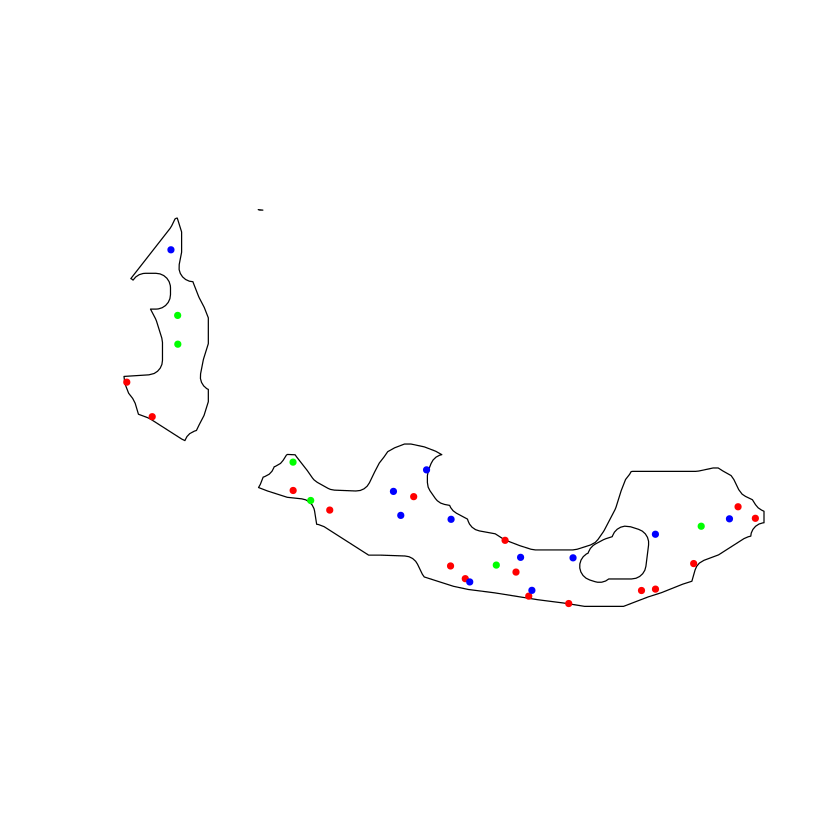

In [54]:
plot(Window(pp[[2]]),main='')
points(df1$x, df1$y,cex=1,pch=20, col='red')
points(df2$x, df2$y,cex=1,pch=20, col='blue')
points(df3$x, df3$y,cex=1,pch=20, col='green')

We can see there is segregation effect.   
To explain this, we need to formally define Vip segregations.